## Introduction

https://www.kaggle.com/kaggle/kaggle-survey-2018

The challenge objective: tell a data story about a subset of the data science community represented in this survey, through a combination of both narrative text and data exploration. A “story” could be defined any number of ways, and that’s deliberate. The challenge is to deeply explore (through data) the impact, priorities, or concerns of a specific group of data science and machine learning practitioners. That group can be defined in the macro (for example: anyone who does most of their coding in Python) or the micro (for example: female data science students studying machine learning in masters programs). This is an opportunity to be creative and tell the story of a community you identify with or are passionate about! 

## Setup

In [1]:
import numpy as np
import pandas as pd
import os
import math
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns 

import plotly.plotly as py
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot 
import warnings

warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)
pd.set_option('display.max_columns', None) 
from ipywidgets import interact, interactive, interact_manual
import ipywidgets as widgets
import colorlover as cl 


color = sns.color_palette()
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

The kaggle survey produced 5 files:

(1) freeformResponses.csv - answers to multiple choice questions. These are *non-randomized* so each row corresponds to a unique person. 

(2) multipleChoiceResponses.csv' - answers in freeform style. These are *randomized*. This means that a row does not correspond to a person, it will most likely be varied. 

In [2]:
### Loading Data 
df_freeform = pd.read_csv('freeFormResponses.csv', 
             header=[0,1])


df_multichoice = pd.read_csv('multipleChoiceResponses.csv',
                             header = [0,1])

schema = pd.read_csv('SurveySchema.csv',header=[0,1])

# header - 0 refers to the original header - 1st line
# of csv files. 1 represents index 0, or first row 
# alternatively. Header=[0,1] puts the 1st row into the 
# header as well. Note if you just do header = [1] the 
# original header will disappear so 0 has to be 
# explicitly included. 


In [3]:
### Format Dataframes (changes MultiIndex to Index)
# Connects 0th header with 1st header by '_" 
df_freeform.columns = \
['_'.join(col) for col in df_freeform.columns] 
df_multichoice.columns = \
['_'.join(col) for col in df_multichoice.columns]
schema.columns = \
['_'.join(col) for col in schema.columns] 

### Obtain columns 
pd.set_option('display.max_columns', None) 


## Distribution of Kaggle Surveyors by Country

In [4]:
country_count_unreset = \
df_multichoice['Q3_In which country do you currently reside?'].value_counts()

country_count_unreset.head()

United States of America    4716
India                       4417
China                       1644
Other                       1036
Russia                       879
Name: Q3_In which country do you currently reside?, dtype: int64

In [5]:
# reset index and convert to data frame
country_count = country_count_unreset.reset_index()
country_count.head()

index  Q3_In which country do you currently reside?
0  United States of America                                          4716
1                     India                                          4417
2                     China                                          1644
3                     Other                                          1036
4                    Russia                                           879

In [6]:
# set two column index after reset 
country_count.columns = ['country', 'people']
country_count.head()

country  people
0  United States of America    4716
1                     India    4417
2                     China    1644
3                     Other    1036
4                    Russia     879

In [7]:
# We will use country codes data available on plotly
# https://github.com/plotly/datasets
# This is purely for reorganization 
country_code = pd.read_csv('2014_world_gdp_with_codes.csv')
country_code.columns


Index(['COUNTRY', 'GDP (BILLIONS)', 'CODE'], dtype='object')

In [8]:
# Let's modify the columns to lower case 
country_code.columns
country_code.columns = country_code.columns.str.lower() 


# country_code.columns = [i.lower() for i in country_code.columns]
# list comprehension is another option 

# Let's change the columns in country_count to something shorter
# like the columns in country_code's 
map_country = {
    'United States of America':'United States',
    'United Kingdom of Great Britain and Northern Ireland':'United Kingdom',
    'South Korea':'"Korea, South"',
    'Viet Nam': 'Vietnam', 
    'Iran, Islamic Republic of...':'Iran',
    'Hong Kong (S.A.R.)':'Hong Kong',
    'Republic of Korea':'"Korea, North"'
}


country_count['country'] = country_count['country'].replace(map_country)
country_count.head()

# note map and replace do not permanently change the original data
# frame without assignment = 



country  people
0  United States    4716
1          India    4417
2          China    1644
3          Other    1036
4         Russia     879

We can observe how many people answered the survey and their country of residence.  
 
Most users, not surprisingly, are predominantly from the USA and India.

In [9]:
country_code.head()

country  gdp (billions) code
0     Afghanistan           21.71  AFG
1         Albania           13.40  ALB
2         Algeria          227.80  DZA
3  American Samoa            0.75  ASM
4         Andorra            4.80  AND

In [10]:
country_count = pd.merge(country_count, country_code, on='country')
country_count.head()

country  people  gdp (billions) code
0  United States    4716         17420.0  USA
1          India    4417          2048.0  IND
2          China    1644         10360.0  CHN
3         Russia     879          2057.0  RUS
4         Brazil     736          2244.0  BRA

In [11]:
data = [ dict(
        type = 'choropleth',
        locations = country_count['code'],
        z = country_count['people'],
        text = country_count['country'],
        colorscale = 'Viridis',
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            title = 'Responders'),
      ) ]

layout = dict(
    title = 'Responders by country',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
iplot( fig, validate=False, filename='d3-world-map' )

Let's focus later analysis on just the USA and India, as they contain the vast majority responders.   

We can utilize the isin boolean check method to relabel and transform. It'll make our analysis easier by labeling other countries as 'Other countries'. 

## Time Taken to Answer Survey

In [12]:
# access row and column using loc, so that Q3 column contains only 4 groups (USA, India, Russia, everything else). This will ease plotting later on. 

df_multichoice['Q3_orig'] = df_multichoice['Q3_In which country do you currently reside?']
df_multichoice.loc[df_multichoice['Q3_In which country do you currently reside?'].isin(['United States of America', 'Russia', 'India']) == False,
              'Q3_In which country do you currently reside?'] = 'Other countries'

df_multichoice.iloc[0:4,0:5] 


Time from Start to Finish (seconds)_Duration (in seconds)  \
0                                                710           
1                                                434           
2                                                718           
3                                                621           

  Q1_What is your gender? - Selected Choice  \
0                                    Female   
1                                      Male   
2                                    Female   
3                                      Male   

   Q1_OTHER_TEXT_What is your gender? - Prefer to self-describe - Text  \
0                                                 -1                     
1                                                 -1                     
2                                                 -1                     
3                                                 -1                     

  Q2_What is your age (# years)? Q3_In which country do you currently reside?  
0                          45-49                     United States of America  
1                          30-34                              Other countries  
2                          30-34                     United States of America  
3                          35-39                     United States of America

In [13]:
df_multichoice['Time from Start to Finish (seconds)_Duration (in minutes)'] = df_multichoice['Time from Start to Finish (seconds)_Duration (in seconds)'] / 60
df_multichoice.filter(like='Time').head(3)

Time from Start to Finish (seconds)_Duration (in seconds)  \
0                                                710           
1                                                434           
2                                                718           

  Q31_Part_10_Which types of data do you currently interact with most often at work or school? (Select all that apply) - Selected Choice - Time Series Data  \
0                                                NaN                                                                                                          
1                                                NaN                                                                                                          
2                                   Time Series Data                                                                                                          

   Time from Start to Finish (seconds)_Duration (in minutes)  
0                                          11.833333          
1                                           7.233333          
2                                          11.966667

In [14]:
df_multichoice.loc[:,df_multichoice.columns.str.contains(pat='Time')].head(3)

Time from Start to Finish (seconds)_Duration (in seconds)  \
0                                                710           
1                                                434           
2                                                718           

  Q31_Part_10_Which types of data do you currently interact with most often at work or school? (Select all that apply) - Selected Choice - Time Series Data  \
0                                                NaN                                                                                                          
1                                                NaN                                                                                                          
2                                   Time Series Data                                                                                                          

   Time from Start to Finish (seconds)_Duration (in minutes)  
0                                          11.833333          
1                                           7.233333          
2                                          11.966667

Text(0.5, 0, 'Time (hours)')

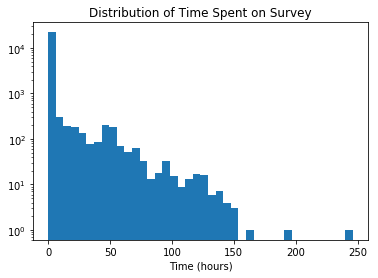

In [15]:
# plot histogram to see distribution of time spent on surveys 
plt.hist(df_multichoice['Time from Start to Finish (seconds)_Duration (in minutes)'] / 60, bins=40);
plt.yscale('log');
plt.title('Distribution of Time Spent on Survey')
plt.xlabel('Time (hours)')

From this, we can conclude that some people left their tabs open and thousands spent their survey tabs open for days. Perhaps we can see more insight using log for xscale and looking at seconds, rather than hours. 

Text(0.5, 0, 'Time (seconds)')

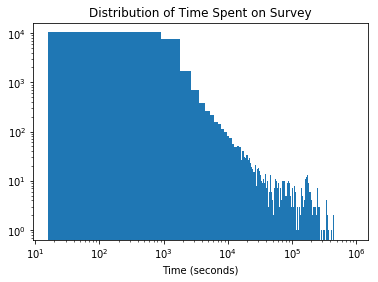

In [16]:
# log graph
plt.hist(df_multichoice['Time from Start to Finish (seconds)_Duration (in seconds)'], bins=1000);
plt.xscale('log');
plt.yscale('log');
plt.title('Distribution of Time Spent on Survey')
plt.xlabel('Time (seconds)')

What we can see is that most people spent less than 1000 seconds on the survey. Tens of thousands opted out of the survey within the first 100 seconds. 

## Distribution of Time Spent on Test by Country

Perhaps we can find some correlation between time spent on surveys and the users' countries of origins. 

In [17]:
# let's look at data for time less than 3 hours 
data = []
for i in df_multichoice['Q3_In which country do you currently reside?'].unique():
    trace = {
            "type": 'violin',
            "x": df_multichoice.loc[(df_multichoice['Q3_In which country do you currently reside?'] == i) & (df_multichoice['Time from Start to Finish (seconds)_Duration (in minutes)'] < 180),
                               'Q3_In which country do you currently reside?'],
            "y": df_multichoice.loc[(df_multichoice['Q3_In which country do you currently reside?'] == i) & (df_multichoice['Time from Start to Finish (seconds)_Duration (in minutes)'] < 180),
                               'Time from Start to Finish (seconds)_Duration (in minutes)'],
            "name": i,
            "meanline": {
                "visible": True
            }
        }
    data.append(trace)

        
fig = {
    "data": data,
    "layout" : {
        "title": "",
        "yaxis": {
            "zeroline": False,
        }
    }
}

fig['layout'].update(title='Time Spent on Test');
iplot(fig)

This graph shows the upper fence for each country - anything above 40-45 minutes is usually an outlier. Notably, people from the USA has a much lower upper fence which could indiciate language barrier slowing down survey completion. The mean tends to be around 20 for these four categories. Interestingly enough, the mean is always higher than the median. Perhaps that's explained by the fact that closing the survey immediately is less impactful as an outlier than leaving the tab open for days. 

In [18]:
# let's look at the distribution for time less than an hour

data = []
for j, c in enumerate(df_multichoice['Q3_In which country do you currently reside?'].unique()):
    df_small = df_multichoice.loc[(df_multichoice['Q3_In which country do you currently reside?'] == c) & (df_multichoice['Time from Start to Finish (seconds)_Duration (in minutes)'] < 60),
                            'Time from Start to Finish (seconds)_Duration (in minutes)']
    trace = go.Histogram(
        x=df_small,
        name=c,
        marker=dict(color=j, opacity=0.5),
        showlegend=False
    )  
    data.append(trace)
fig = go.Figure(data=data)
fig['layout'].update(height=400, width=800, barmode='overlay', title='Distribution of time spent on test by country');
iplot(fig);

Each country tends to exhibit users with similar psychological patterns. The bell pattern between 10 to 25 minutes is, hypothetically speaking, users who took the survey seriously. 

## Gender and Age Distribution

In [19]:
df_multichoice.iloc[:,1].value_counts().sum()

23859

In [20]:
# Gender Pie Graph
temp_series = df_multichoice.iloc[:,1].value_counts() 
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series/ temp_series.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout= go.Layout(title='Gender Distribution')

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename = 'gender') 

In [21]:
# Gender & Age Combined Bar Graph
data = []
for i in df_multichoice['Q1_What is your gender? - Selected Choice'].unique():
    trace = go.Bar(
        x=df_multichoice.loc[df_multichoice['Q1_What is your gender? - Selected Choice'] == i, 'Q2_What is your age (# years)?'].value_counts().sort_index().index,
        y=df_multichoice.loc[df_multichoice['Q1_What is your gender? - Selected Choice'] == i, 'Q2_What is your age (# years)?'].value_counts().sort_index().values,
        name=i
    )
    data.append(trace)
layout = go.Layout(
    barmode='stack'
)
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='stacked-bar')

To take a closer look at the percentages, we can use crosstab to see a frequency table. The colors are arranged from low to high vertically, so that in each age group you can see what % of surveyors gave a particular answer. 

### Based on the graphs, we can make the following conclusions: 

- When looking at ages, most users seem to fall between 22 and 29 years.  3  3 3 3

- It is interesting to note that 48% of those who answered "prefer to self-describe" were between the ages 25 and 34. 

- Ages 22-29 is the prominent age group for those who answered "prefer not to say", taking 52% of the total answer. 
 
- Most female surveyors are relatively young, as 79% are between 18 and 34, and predominantly between 22 and 29. This speaks volume about data science's rise in popularity among this generation as a career path. 

- Those who answered "prefer not to say" 

We can, in addition, see that Kaggle users are predominantly male across all age groups. Let's see if the distributions are a bit different across countries. 

## Age Distribution

In [ ]:
# let's find where the age column is 
df_multichoice.loc[:,df_multichoice.columns.str.contains(pat=' age')].head(2)

In [28]:
df_multichoice

Time from Start to Finish (seconds)_Duration (in seconds)  \
1                                                434           
2                                                718           
3                                                621           

  Q1_What is your gender? - Selected Choice  \
1                                      Male   
2                                    Female   
3                                      Male   

   Q1_OTHER_TEXT_What is your gender? - Prefer to self-describe - Text  \
1                                                 -1                     
2                                                 -1                     
3                                                 -1                     

  Q2_What is your age (# years)? Q3_In which country do you currently reside?  \
1                          30-34                              Other countries   
2                          30-34                     United States of America   
3                          35-39                     United States of America   

  Q4_What is the highest level of formal education that you have attained or plan to attain within the next 2 years?  \
1                                  Bachelor’s degree                                                                   
2                                    Master’s degree                                                                   
3                                    Master’s degree                                                                   

  Q5_Which best describes your undergraduate major? - Selected Choice  \
1                 Engineering (non-computer focused)                    
2      Computer science (software engineering, etc.)                    
3  Social sciences (anthropology, psychology, soc...                    

  Q6_Select the title most similar to your current role (or most recent title if retired): - Selected Choice  \
1                                              Other                                                           
2                                     Data Scientist                                                           
3                                       Not employed                                                           

   Q6_OTHER_TEXT_Select the title most similar to your current role (or most recent title if retired): - Other - Text  \
1                                                  0                                                                    
2                                                 -1                                                                    
3                                                 -1                                                                    

  Q7_In what industry is your current employer/contract (or your most recent employer if retired)? - Selected Choice  \
1                          Manufacturing/Fabrication                                                                   
2                                     I am a student                                                                   
3                                                NaN                                                                   

   Q7_OTHER_TEXT_In what industry is your current employer/contract (or your most recent employer if retired)? - Other - Text  \
1                                                 -1                                                                            
2                                                 -1                                                                            
3                                                 -1                                                                            

  Q8_How many years of experience do you have in your current role?  \
1                                               5-10                  
2                                                0-1                  
3               